In [ ]:
# get the latest version from pypi 
# for other installations approaches, see https://dynamo-release.readthedocs.io/en/latest/ten_minutes_to_dynamo.html#how-to-install
!pip install dynamo-release --upgrade --quiet

In [1]:
import mygene
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import numpy as np
import dynamo as dyn
dyn.get_all_dependencies_version()

package,dynamo-release,tqdm,anndata,cvxopt,hdbscan,loompy,matplotlib,numba,numpy,pandas,pynndescent,python-igraph,scikit-learn,scipy,seaborn,setuptools,statsmodels,trimap,umap-learn,numdifftools,colorcet
version,0.95.0,4.48.0,0.7.4,1.2.3,0.8.26,3.0.6,3.3.0,0.48.0,1.19.1,1.1.0,0.4.8,0.8.2,0.23.1,1.5.2,0.9.0,49.3.1,0.11.1,1.0.12,0.4.3,0.9.39,2.0.2


In [2]:
# emulate ggplot2 plotting styple with white background

dyn.configuration.set_figure_params('dynamo', background='white')  

In [3]:
import pandas as pd 
from scipy.sparse import csr_matrix

In [4]:
def ensemble2gene_symbol(ensemble_names, species):
    
    mg = mygene.MyGeneInfo()
    geneSyms = mg.querymany(ensemble_names, scopes='ensembl.gene', fields='symbol', species='human',)
    var_pd = pd.DataFrame(geneSyms)

    return var_pd


In [5]:
def load_raw_data(exp, basedir = '/home/xqiu/proj/Aristotle/data/scSLAM_seq_data/NASC_seq/'):
    new_RNA = pd.read_csv(basedir + 'GSE128273_exp' + exp + '_newcounts.csv', index_col=0, delimiter=',')
    old_RNA = pd.read_csv(basedir + 'GSE128273_exp' + exp + '_oldcounts.csv', index_col=0, delimiter=',')
    tot_RNA = pd.read_csv(basedir + 'GSE128273_exp' + exp + '_readcounts.csv', index_col=0, delimiter=',')

    new_RNA.fillna(0, inplace=True)
    old_RNA.fillna(0, inplace=True)
    tot_RNA.fillna(0, inplace=True)

    new_RNA.head()

    if exp == "1":         
        split_array = [new_RNA.columns.str.split('_', n=5)[i] for i in range(len(new_RNA.columns.str.split('_', n=5)))]
        split_df = pd.DataFrame(split_array, columns=['Plate', 'Well', 'Exp', 'CellType', '4sU'])
    else: 
        split_array = [new_RNA.columns.str.split('_', n=6)[i] for i in range(len(new_RNA.columns.str.split('_', n=6)))]
        split_df = pd.DataFrame(split_array, columns=['Plate', 'Well', 'Exp', 'CellType', '4sU', 'drug_treatment'])

    var_df_ = ensemble2gene_symbol(new_RNA.index.values, 'human')
    
    return new_RNA, old_RNA, tot_RNA, var_df_, split_df


In [6]:
new_RNA, old_RNA, tot_RNA, var_df_, split_df = load_raw_data("1", basedir = '/Users/xqiu/Dropbox (Personal)/Projects/dynamo-release/debug/data/')



querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

In [7]:
import time
from anndata import AnnData

exp1_gene_list = ["MYC", "PDLIM5", "GAPDH"]
exp2_gene_list = ["EGR1", "FOS", "GAPDH", "ACTB"]
color = 'Exp'
basis = 'umap'

def dynamo_analysis(adata, genes, color):
#     adata.layers['new'], adata.layers['total'] = csr_matrix(adata.layers['unspliced']), csr_matrix(
#         adata.layers['spliced'])
#     del adata.layers['unspliced'], adata.layers['spliced']
    adata.obs.loc[:, 't'] = adata.obs.loc[:, '4sU']
    adata.obs.loc[:, 't'] = adata.obs.loc[:, 't'].map({"30min4sU": 0.5, "60min4sU": 1, "control": 0, "unlabelled": 0})

    # normalization
    dyn.pp.recipe_monocle(adata, n_top_genes=2000)

    # smoothing (calculate 1/2 moments); calculate kinetic parameters and high dimensional velocity vector
    start_time = time.time()
    dyn.tl.dynamics(adata, model='stochastic') 
    # or dyn.tl.dynamics(adata, model='stochastic')
    # or dyn.tl.dynamics(adata, model='stochastic', est_method='negbin'
    print("--- %s seconds ---" % (time.time() - start_time))
    print("experiment type is ", adata.uns['dynamics']["experiment_type"])

    dyn.tl.reduceDimension(adata, reduction_method='umap')

    # velocity on new data; new_umap: new layer
    dyn.tl.cell_velocities(adata, n_recurse_neighbors=2, M_diff=0.2, epsilon=None, adaptive_local_kernel=True, tol=1e-7)
    dyn.pl.cell_wise_vectors(adata, pointsize=0.25, basis='umap', figsize=(3, 3), alpha=0.6)

    # velocity on total data; new_umap: new layer
    dyn.tl.cell_velocities(adata, n_recurse_neighbors=2, M_diff=0.2, epsilon=None, adaptive_local_kernel=True, tol=1e-7,
                           ekey='X_total', vkey='velocity_S', min_r2=-10)
    dyn.pl.cell_wise_vectors(adata, pointsize=0.25, basis='umap', figsize=(3, 3), alpha=0.6)

    # subset cells with 4sU
    fourSU = adata[adata.obs.loc[:, '4sU'] == '60min4sU', :]
    dyn.pl.cell_wise_vectors(fourSU, pointsize=0.25, basis='umap', figsize=(3, 3), alpha=0.6)

    # subset cells without 4sU
    non_fourSU = adata[adata.obs.loc[:, '4sU'] != '60min4sU', :]
    dyn.pl.cell_wise_vectors(non_fourSU, pointsize=0.25, basis='umap', figsize=(3, 3), alpha=0.6)
    genes = adata.var_names[adata.var_names.isin(genes)].tolist()
    if len(genes) == 0: genes = adata.var_names[adata.var.use_for_velocity].tolist()[:3]
    genes.append(color)                         
    # different embedding plot
    dyn.pl.pca(adata, color=exp1_gene_list, ncols=3, pointsize=0.25, figsize=(3, 3))
    dyn.pl.umap(adata, color=exp1_gene_list, ncols=3, pointsize=0.25, figsize=(3, 3))

    # plot phase portrait
#     dyn.pl.phase_portraits(adata, genes=adata.var.index[adata.var.use_for_velocity][:3], ncols=3, figsize=(3, 3))

    # grid velocity
    dyn.pl.grid_vectors(adata, color=exp1_gene_list, pointsize=0.25, basis=basis, figsize=(3, 3))
    # streamline plot
    dyn.pl.streamline_plot(adata, color=exp1_gene_list, pointsize=0.25, basis=basis, figsize=(3, 3),
                            min_mass=1e-3)

    dyn.vf.VectorField(adata, basis=basis, dims=[0, 1])

    dyn.pl.topography(adata, basis=basis)

    # plot phase but with the dot (n) and dot (t)
    gene = adata.var.index[adata.var.use_for_velocity][0]
    X, Y, V, F = adata[:, gene].layers['M_t'], adata[:, gene].layers['M_n'], \
                 adata[:, gene].layers['velocity_S'], adata[:, gene].layers['velocity_U']

    def one_shot_k(gamma, t):
        k = 1 - np.exp(- gamma * t)
        return k

    k = one_shot_k(adata[:, gene].var['gamma'][0], 1)
    X, Y, V, F = X.A, Y.A, V.A, F.A
    # F[F > 0] = 0
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(X, Y)
    ax.quiver(X, Y, V, F)
    xnew = np.linspace(0, X.max())
    ax.plot(xnew, xnew * k, c='red')
    plt.show()


In [8]:
var = pd.DataFrame(new_RNA.index)
var.columns = ['id']
var_df = var_df_.loc[~ var_df_.loc[:, 'query'].duplicated(), :]

var = var.merge(var_df, left_on='id', right_on='query', )

var_df = var_df.set_index('query')
var_df = var_df.loc[new_RNA.index, :]
var_df = var_df.set_index('symbol')

dyn_adata_NASC_seq_1 = AnnData(csr_matrix(tot_RNA.values.T),
    obs = split_df,
    var = var_df, 
    layers=dict(
        new=csr_matrix(new_RNA.values.T),
        total = csr_matrix(tot_RNA.values.T))) 

dyn_adata_NASC_seq_1

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 192 × 58428
    obs: 'Plate', 'Well', 'Exp', 'CellType', '4sU'
    var: '_id', '_score', 'notfound'
    layers: 'new', 'total'

In [9]:
dyn_adata_NASC_seq_1.obs.loc[:, 't'] = dyn_adata_NASC_seq_1.obs.loc[:, '4sU']
dyn_adata_NASC_seq_1.obs.loc[:, 't'] = dyn_adata_NASC_seq_1.obs.loc[:, 't'].map({"30min4sU": 0.5, "60min4sU": 1, "control": 0, "unlabelled": 0})


In [10]:
dyn_adata_NASC_seq_1 = dyn_adata_NASC_seq_1[:, ~ dyn_adata_NASC_seq_1.var_names.isna()]

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/preprocessing/utils.py:549: RuntimeWarning: invalid value encountered in true_divide
  var_ntr = adata.layers['new'].sum(0) / adata.layers['total'].sum(0)
/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/ann

--- 17.700100898742676 seconds ---
experiment type is  one-shot


/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 192/192 [00:00<00:00, 1230.41it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 192/192 [00:00<00:00, 4218.19it/s]
/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/plot/scVectorField.py:513: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 300x300 with 0 Axes>

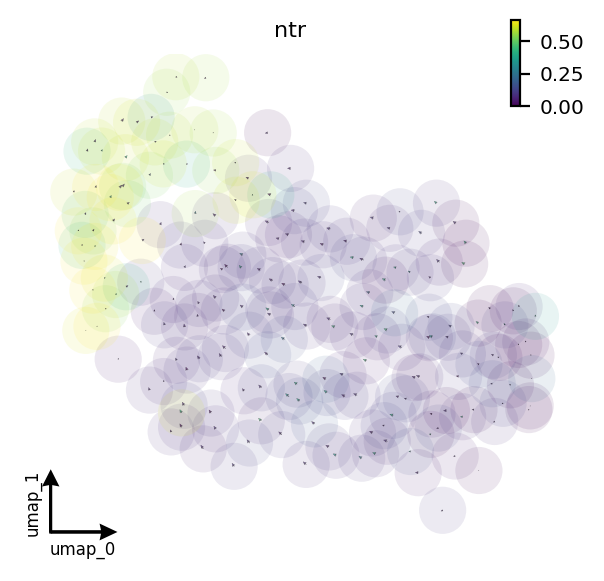

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 192/192 [00:00<00:00, 1411.50it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 192/192 [00:00<00:00, 4463.36it/s]
/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/plot/scVectorField.py:513: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 300x300 with 0 Axes>

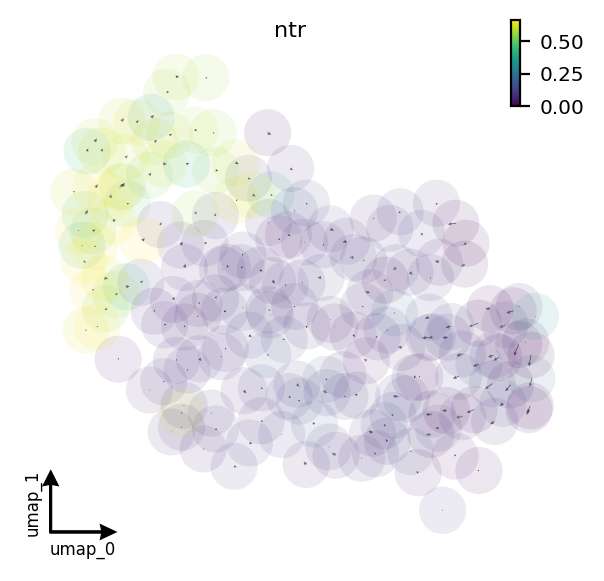

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/plot/scVectorField.py:513: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 300x300 with 0 Axes>

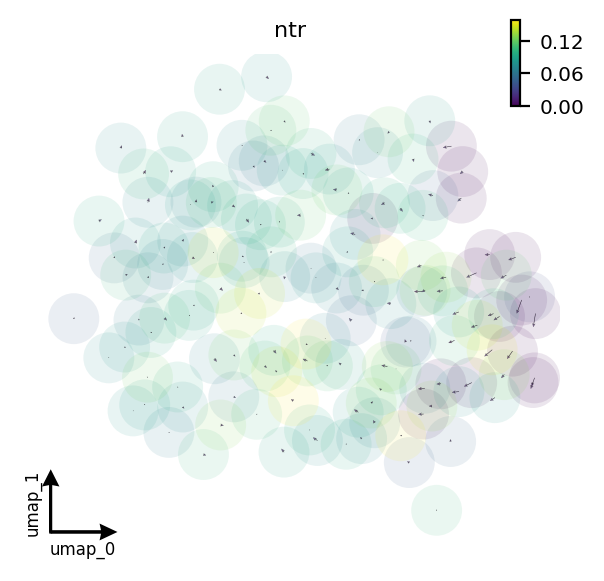

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/plot/scVectorField.py:513: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 300x300 with 0 Axes>

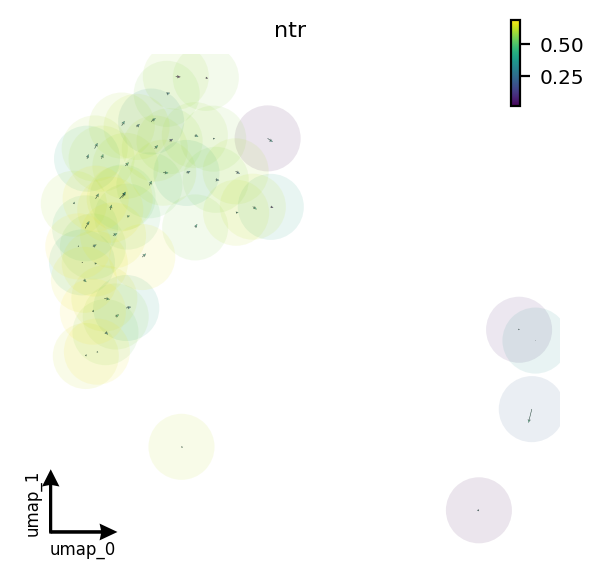

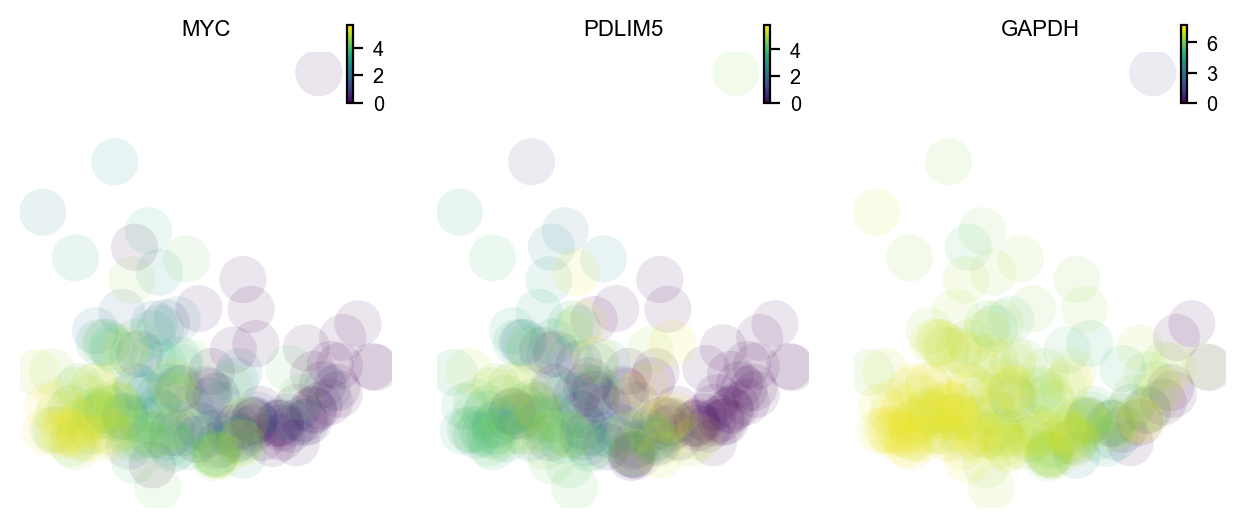

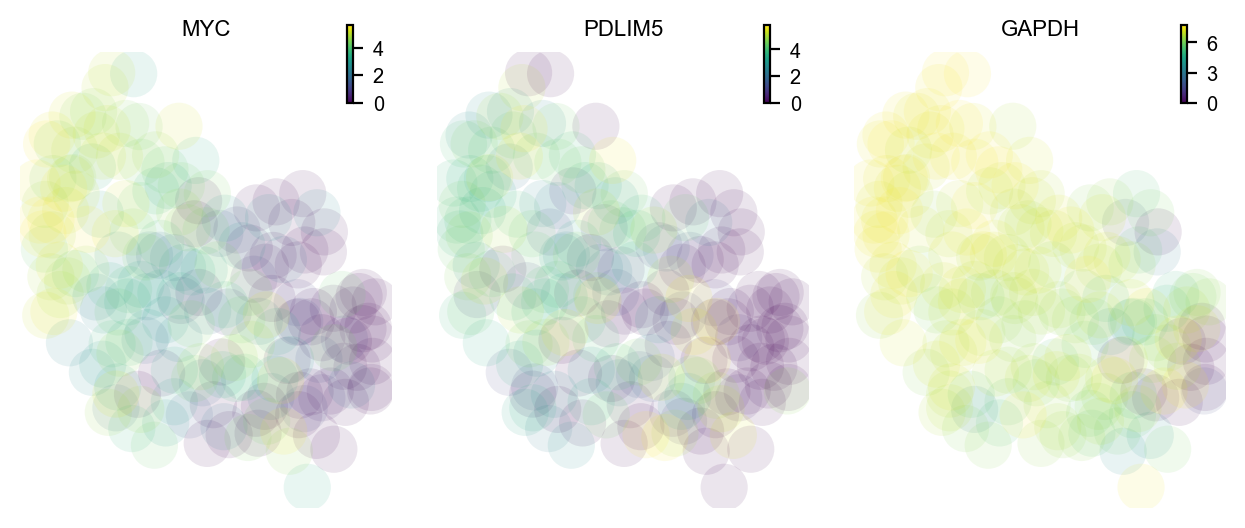

/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/plot/scVectorField.py:784: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


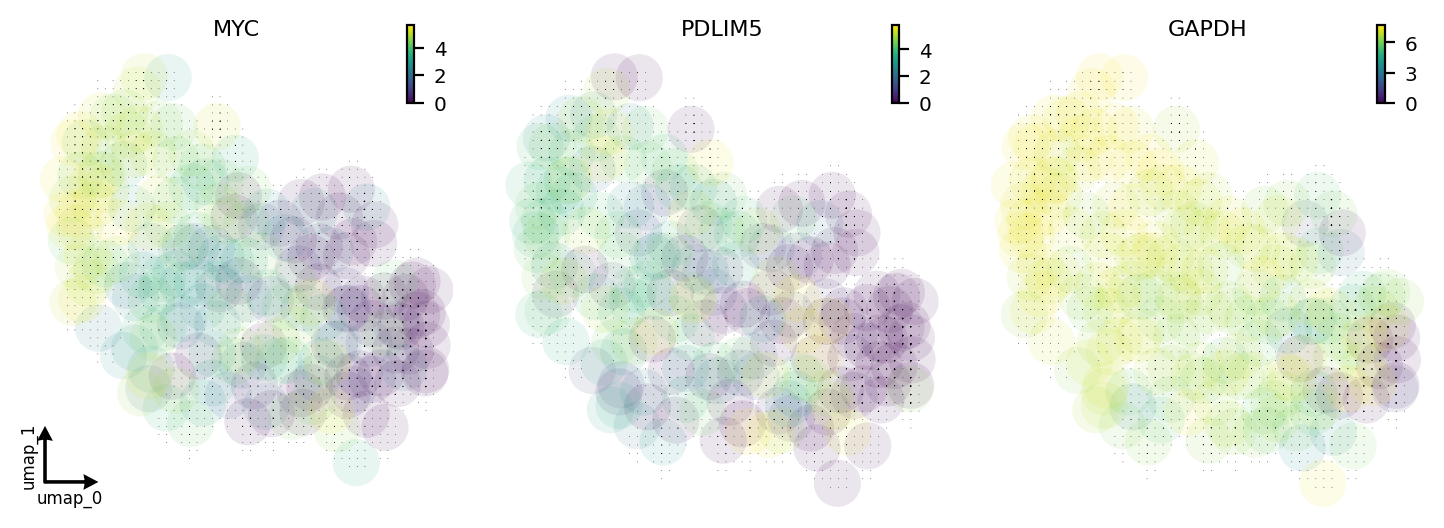

/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/plot/scVectorField.py:1060: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


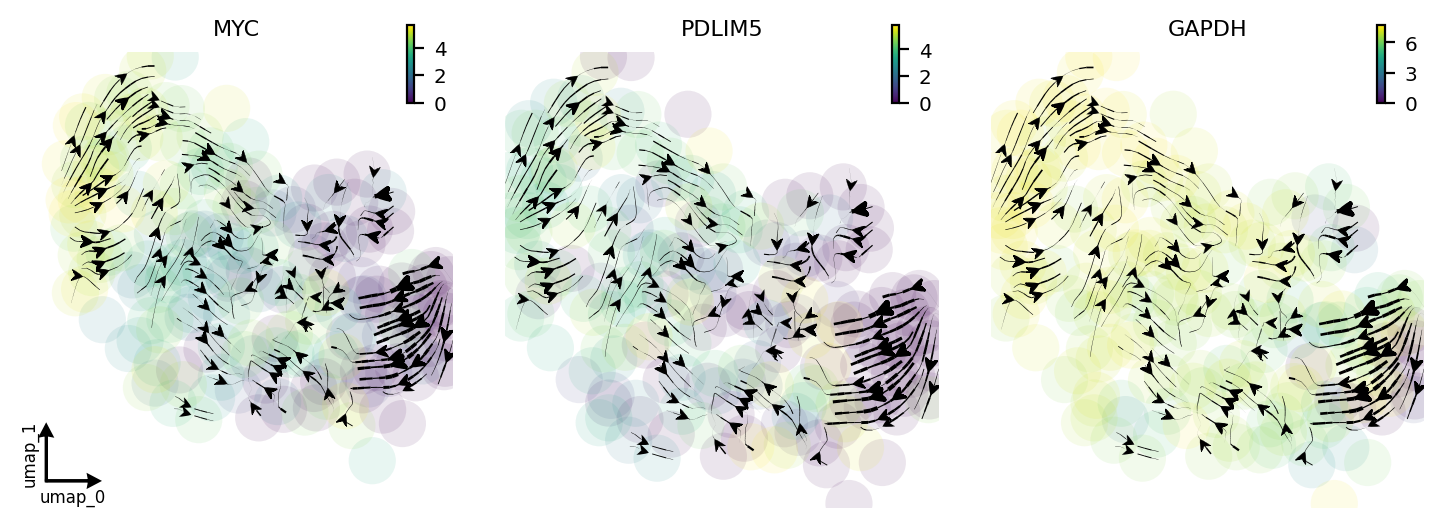

<Figure size 600x400 with 0 Axes>

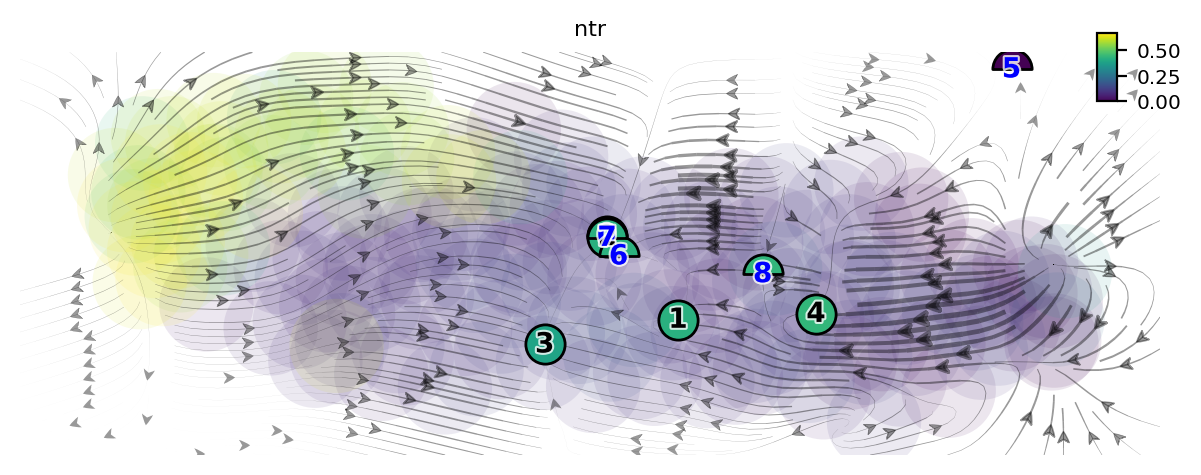

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


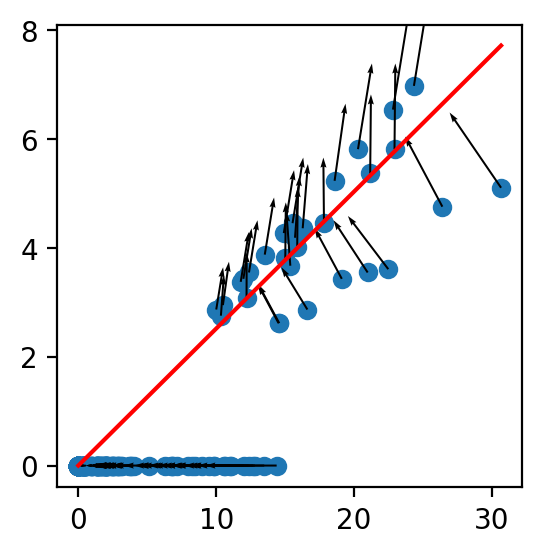

In [11]:
dynamo_analysis(dyn_adata_NASC_seq_1, exp1_gene_list, color='Exp')